In [1]:
import os
import cv2
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter

import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical


In [ ]:
# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50 
NUM_CLASSES = 4  # Benign, Pro-B, Pre-B, Early Pre-B
DATA_PATH = "dataset"
SEED = 42


In [3]:

# Set random seeds for reproducibility
tf.random.set_seed(SEED) 
np.random.seed(SEED)
random.seed(SEED)


In [4]:
# ==================== DATA CLEANING ====================
def clean_image(image):
    """Remove noise and artifacts from images"""
    # Convert to grayscale for cleaning
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply median blur to remove noise
    cleaned = cv2.medianBlur(gray, 3)
    
    # Threshold to remove extreme dark/light pixels
    _, thresh = cv2.threshold(cleaned, 5, 255, cv2.THRESH_BINARY)
    
    # Find contours and keep largest (assumed to be cell)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        mask = np.zeros_like(gray)
        cv2.drawContours(mask, [largest_contour], 0, 255, -1)
        cleaned = cv2.bitwise_and(cleaned, cleaned, mask=mask)
    
    # Convert back to BGR
    cleaned = cv2.cvtColor(cleaned, cv2.COLOR_GRAY2BGR)
    return cleaned

In [5]:
# ==================== DATA PREPROCESSING ====================
def enhance_image(image):
    """Enhance medical images using CLAHE and sharpening"""
    # Convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    
    # Merge enhanced L channel back
    limg = cv2.merge((cl, a, b))
    enhanced = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    
    # Apply sharpening
    gaussian = cv2.GaussianBlur(enhanced, (0, 0), 2.0)
    sharpened = cv2.addWeighted(enhanced, 1.5, gaussian, -0.5, 0)
    
    return sharpened

def preprocess_image(image_path):
    """Complete preprocessing pipeline"""
    img = cv2.imread(image_path)
    if img is None:
        return None
    
    img = clean_image(img)
    img = cv2.resize(img, IMG_SIZE)
    img = enhance_image(img)
    img = img / 255.0  # Normalize
    
    return img

In [7]:
# ==================== FEATURE EXTRACTION ====================
def extract_features(images):
    """Extract handcrafted features (color and texture)"""
    features = []
    for img in images:
        # Color features (mean and std of each channel)
        means = cv2.mean(img)[:3]
        stds = cv2.meanStdDev(img)[1].flatten()
        # Texture features (LBP)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        lbp = local_binary_pattern(gray, 8, 1, method='uniform')
        hist, _ = np.histogram(lbp, bins=10, range=(0, 10))
        hist = hist / hist.sum()  # Normalize
        
        features.append(np.concatenate([means, stds, hist]))
    
    return np.array(features)

In [8]:
# ==================== DATA LOADING ====================
def load_dataset(base_path):
    images = []
    labels = []
    class_names = sorted(os.listdir(base_path))
    
    print(f"Classes found: {class_names}")
    
    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(base_path, class_name)
        print(f"Loading {class_name} images from {class_path}")
        
        for file_name in os.listdir(class_path):
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_path, file_name)
                img = preprocess_image(img_path)
                if img is not None:
                    images.append(img)
                    labels.append(class_idx)
    
    return np.array(images), np.array(labels), class_names


In [9]:
# Load dataset
print("Loading training data...")
train_images, train_labels, class_names = load_dataset(os.path.join(DATA_PATH, "train"))


Loading training data...
Classes found: ['Benign', 'Malignant_Early_Pre-B', 'Malignant_Pre-B', 'Malignant_Pro-B']
Loading Benign images from dataset\train\Benign
Loading Malignant_Early_Pre-B images from dataset\train\Malignant_Early_Pre-B
Loading Malignant_Pre-B images from dataset\train\Malignant_Pre-B
Loading Malignant_Pro-B images from dataset\train\Malignant_Pro-B


In [10]:
print("Loading test data...")
test_images, test_labels, _ = load_dataset(os.path.join(DATA_PATH, "test"))


Loading test data...
Classes found: ['Benign', 'Malignant_Early_Pre-B', 'Malignant_Pre-B', 'Malignant_Pro-B']
Loading Benign images from dataset\test\Benign
Loading Malignant_Early_Pre-B images from dataset\test\Malignant_Early_Pre-B
Loading Malignant_Pre-B images from dataset\test\Malignant_Pre-B
Loading Malignant_Pro-B images from dataset\test\Malignant_Pro-B


In [11]:
print("\nDataset summary:")
print(f"Training images: {len(train_images)}")
print(f"Test images: {len(test_images)}")
print(f"Class distribution: {Counter(train_labels)}")



Dataset summary:
Training images: 2608
Test images: 832
Class distribution: Counter({np.int64(1): 704, np.int64(2): 704, np.int64(3): 704, np.int64(0): 496})


In [12]:
# ==================== CLASS IMBALANCE HANDLING ====================
# Convert to one-hot encoding
train_labels_onehot = to_categorical(train_labels, num_classes=NUM_CLASSES)
test_labels_onehot = to_categorical(test_labels, num_classes=NUM_CLASSES)

# Apply SMOTE
print("\nOriginal class distribution:", Counter(train_labels))
print("Applying SMOTE for class balancing...")

train_images_flat = train_images.reshape(train_images.shape[0], -1)
smote = SMOTE(random_state=SEED)
train_images_flat_res, train_labels_res = smote.fit_resample(train_images_flat, train_labels)

# Reshape back to images
train_images_res = train_images_flat_res.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 3)
train_labels_res_onehot = to_categorical(train_labels_res, num_classes=NUM_CLASSES)

print("Resampled class distribution:", Counter(train_labels_res))



Original class distribution: Counter({np.int64(1): 704, np.int64(2): 704, np.int64(3): 704, np.int64(0): 496})
Applying SMOTE for class balancing...
Resampled class distribution: Counter({np.int64(0): 704, np.int64(1): 704, np.int64(2): 704, np.int64(3): 704})


In [13]:
# ==================== DATA AUGMENTATION ====================
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [ ]:
# ==================== MODEL BUILDING ====================
def build_model(input_shape=(224, 224, 3), num_classes=4):
    # Load DenseNet201 without top layers
    base_model = applications.DenseNet201(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    
    # Freeze base layers initially
    base_model.trainable = False
    
    # Build custom top layers
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    
    return model

# Build initial model
model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1920)           │         7,680 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       491,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,822,468 (71.80 MB)

 Trainable params: 496,644 (1.89 MB)

 Non-trainable params: 18,325,824 (69.91 MB)

In [15]:
# ==================== CALLBACKS ====================
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        verbose=1,
        restore_best_weights=True,
        min_delta=0.001
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=8,
        verbose=1,
        min_lr=1e-7
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

In [16]:
# ==================== TRAINING ====================
# Split into train/validation
X_train, X_val, y_train, y_val = train_test_split(
    train_images_res,
    train_labels_res_onehot,
    test_size=0.15,
    stratify=train_labels_res,
    random_state=SEED
)

print(f"\nTraining data: {X_train.shape}")
print(f"Validation data: {X_val.shape}")

# Train initial model
print("\nTraining initial model...")
initial_history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    callbacks=callbacks
)


Training data: (2393, 224, 224, 3)
Validation data: (423, 224, 224, 3)

Training initial model...


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4524 - auc: 0.7132 - loss: 1.3561 - precision: 0.4895 - recall: 0.3650
Epoch 1: val_accuracy improved from -inf to 0.76359, saving model to best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 592s 7s/step - accuracy: 0.4542 - auc: 0.7148 - loss: 1.3515 - precision: 0.4916 - recall: 0.3670 - val_accuracy: 0.7636 - val_auc: 0.9123 - val_loss: 0.7173 - val_precision: 0.8373 - val_recall: 0.6690 - learning_rate: 1.0000e-04
Epoch 2/50
 1/74 ━━━━━━━━━━━━━━━━━━━━ 7:57 7s/step - accuracy: 0.8750 - auc: 0.9549 - loss: 0.5085 - precision: 0.8929 - recall: 0.7812

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.76359 to 0.76832, saving model to best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8750 - auc: 0.9549 - loss: 0.5085 - precision: 0.8929 - recall: 0.7812 - val_accuracy: 0.7683 - val_auc: 0.9138 - val_loss: 0.7114 - val_precision: 0.8382 - val_recall: 0.6738 - learning_rate: 1.0000e-04
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7992 - auc: 0.9521 - loss: 0.5304 - precision: 0.8475 - recall: 0.7471
Epoch 3: val_accuracy improved from 0.76832 to 0.86998, saving model to best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 535s 7s/step - accuracy: 0.7995 - auc: 0.9522 - loss: 0.5297 - precision: 0.8476 - recall: 0.7476 - val_accuracy: 0.8700 - val_auc: 0.9775 - val_loss: 0.3907 - val_precision: 0.9008 - val_recall: 0.8156 - learning_rate: 1.0000e-04
Epoch 4/50
 1/74 ━━━━━━━━━━━━━━━━━━━━ 10:42 9s/step - accuracy: 0.9062 - auc: 0.9899 - loss: 0.2665 - precision: 0.9062 - recall: 0.9062
Epoch 4: val_accuracy improved from

In [17]:
# ==================== FINE-TUNING ====================
def fine_tune_model(model):
    """Unfreeze deeper layers for fine-tuning"""
    # Make base model trainable
    model.trainable = True
    
    # Freeze first 150 layers of the base model
    for layer in model.layers[:150]:
        layer.trainable = False
    
    # Recompile with lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.00001),  # Lower LR for fine-tuning
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    
    return model

# Load best initial model
model = tf.keras.models.load_model('best_model.keras')

# Fine-tune the model
print("\nFine-tuning the model...")
model = fine_tune_model(model)

# Fine-tuning callbacks
fine_tune_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5,
        verbose=1,
        min_lr=1e-7
    ),
    ModelCheckpoint(
        'fine_tuned_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

# Train with fine-tuning
fine_tune_history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    validation_data=(X_val, y_val),
    epochs=int(EPOCHS * 0.5),  # Fewer epochs for fine-tuning
    callbacks=fine_tune_callbacks
)


Fine-tuning the model...
Epoch 1/25


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9723 - auc: 0.9986 - loss: 0.0803 - precision: 0.9740 - recall: 0.9709
Epoch 1: val_accuracy improved from -inf to 0.97872, saving model to fine_tuned_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 498s 6s/step - accuracy: 0.9722 - auc: 0.9986 - loss: 0.0804 - precision: 0.9739 - recall: 0.9709 - val_accuracy: 0.9787 - val_auc: 0.9995 - val_loss: 0.0520 - val_precision: 0.9810 - val_recall: 0.9787 - learning_rate: 1.0000e-05
Epoch 2/25
 1/74 ━━━━━━━━━━━━━━━━━━━━ 6:08 5s/step - accuracy: 0.9688 - auc: 0.9993 - loss: 0.0563 - precision: 0.9677 - recall: 0.9375
Epoch 2: val_accuracy did not improve from 0.97872
74/74 ━━━━━━━━━━━━━━━━━━━━ 69s 878ms/step - accuracy: 0.9688 - auc: 0.9993 - loss: 0.0563 - precision: 0.9677 - recall: 0.9375 - val_accuracy: 0.9787 - val_auc: 0.9995 - val_loss: 0.0520 - val_precision: 0.9810 - val_recall: 0.9787 - learning_rate: 1.0000e-05
Epoch 3/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9613 - auc: 0.997

In [18]:
# ==================== EVALUATION ====================
# Load best fine-tuned model
model = tf.keras.models.load_model('fine_tuned_model.keras')


In [19]:
# Evaluate on test set
print("\nEvaluating on test set...")
test_results = model.evaluate(test_images, test_labels_onehot)
print("\nTest Set Evaluation:")
print(f"Loss: {test_results[0]:.4f}")
print(f"Accuracy: {test_results[1]:.4f}")
print(f"Precision: {test_results[2]:.4f}")
print(f"Recall: {test_results[3]:.4f}")
print(f"AUC: {test_results[4]:.4f}")



Evaluating on test set...
26/26 ━━━━━━━━━━━━━━━━━━━━ 154s 5s/step - accuracy: 0.9878 - auc: 0.9987 - loss: 0.0520 - precision: 0.9889 - recall: 0.9878

Test Set Evaluation:
Loss: 0.0555
Accuracy: 0.9856
Precision: 0.9880
Recall: 0.9856
AUC: 0.9982


In [20]:
# Predictions
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)


26/26 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step


In [21]:
# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, y_pred_classes, target_names=class_names))



Classification Report:
                       precision    recall  f1-score   support

               Benign       0.99      0.99      0.99       208
Malignant_Early_Pre-B       0.98      1.00      0.99       208
      Malignant_Pre-B       1.00      0.97      0.98       208
      Malignant_Pro-B       0.97      0.99      0.98       208

             accuracy                           0.99       832
            macro avg       0.99      0.99      0.99       832
         weighted avg       0.99      0.99      0.99       832



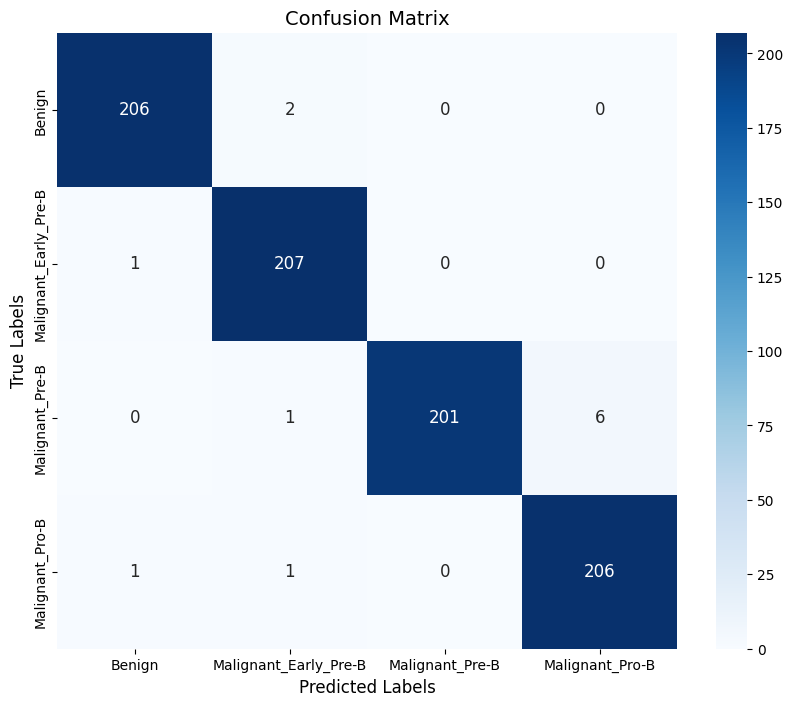

In [22]:
# Confusion matrix heatmap
cm = confusion_matrix(test_labels, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            annot_kws={"size": 12})
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

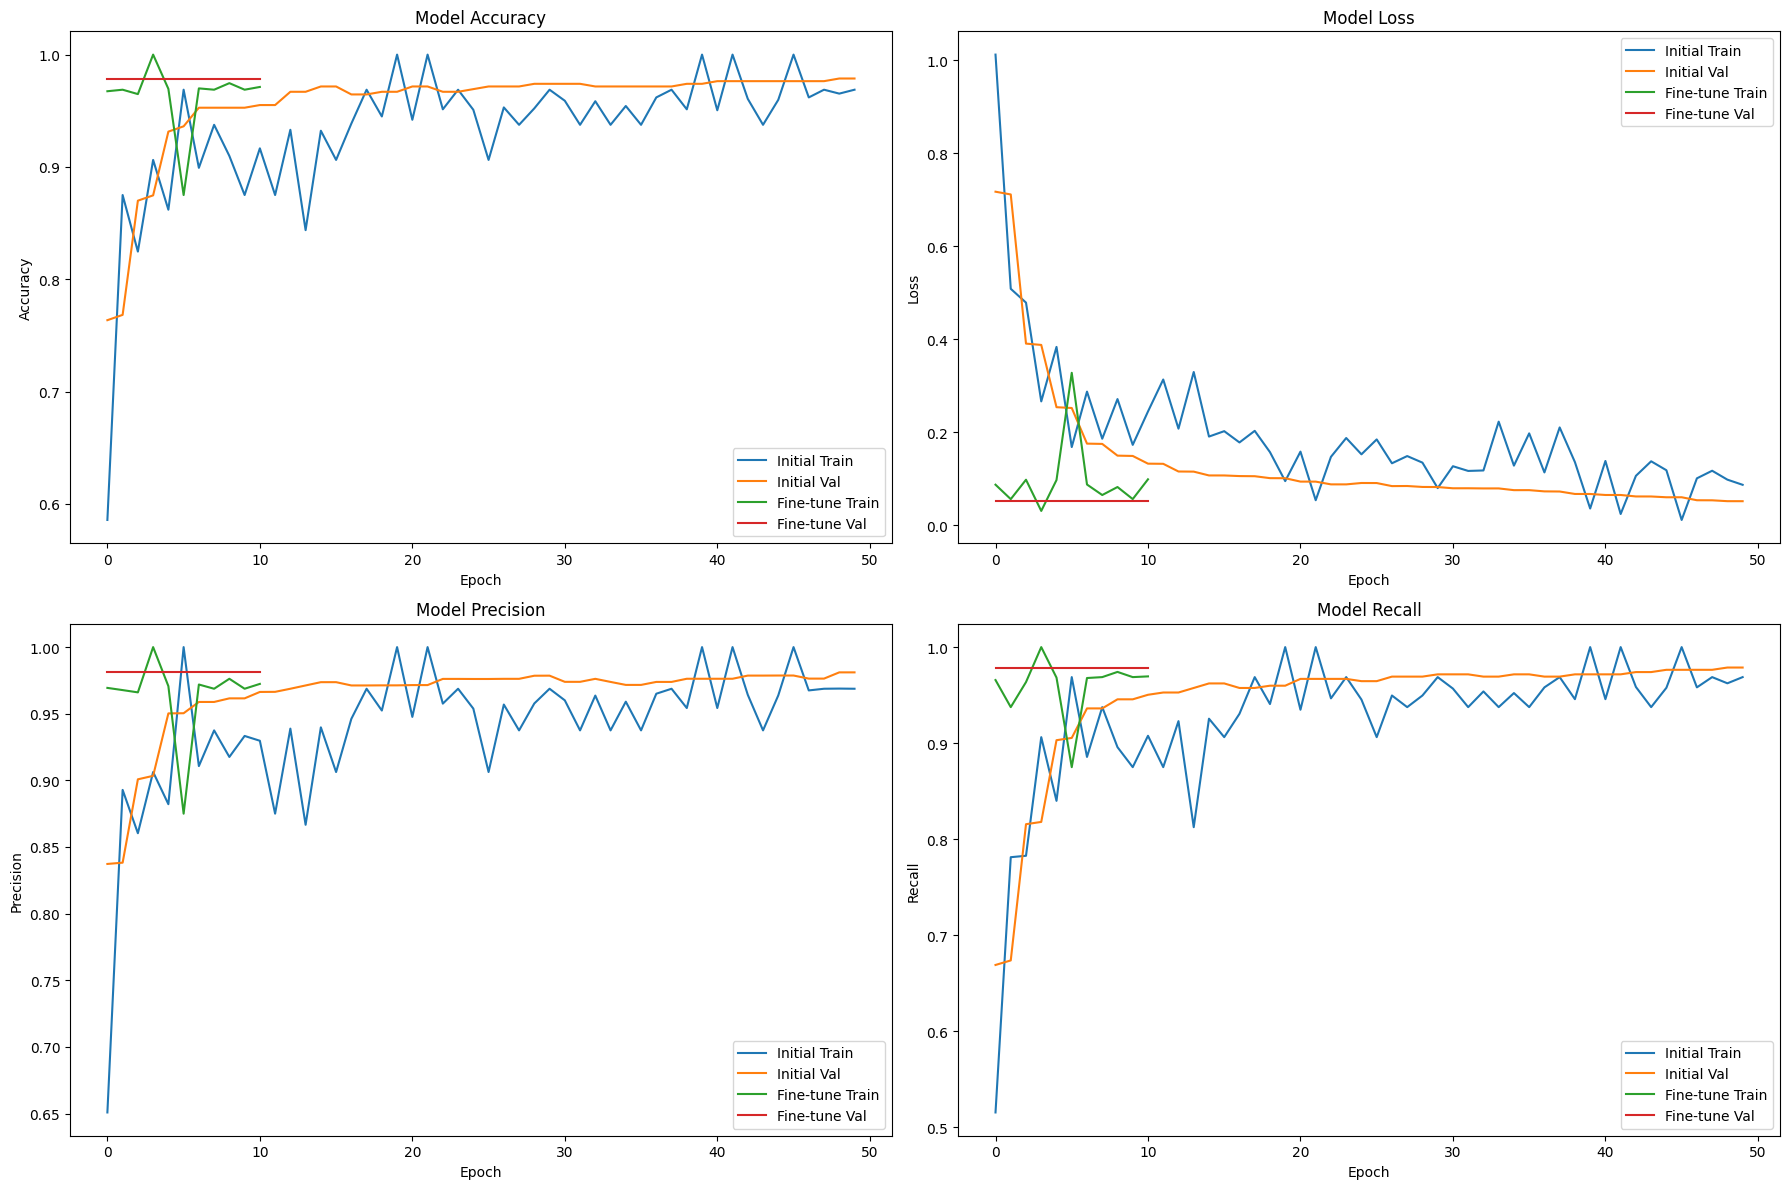

In [23]:
# ==================== VISUALIZATION ====================
def plot_history(initial_history, fine_tune_history=None):
    fig, ax = plt.subplots(2, 2, figsize=(18, 12))
    
    # Accuracy
    ax[0, 0].plot(initial_history.history['accuracy'], label='Initial Train')
    ax[0, 0].plot(initial_history.history['val_accuracy'], label='Initial Val')
    if fine_tune_history:
        ax[0, 0].plot(fine_tune_history.history['accuracy'], label='Fine-tune Train')
        ax[0, 0].plot(fine_tune_history.history['val_accuracy'], label='Fine-tune Val')
    ax[0, 0].set_title('Model Accuracy', fontsize=12)
    ax[0, 0].set_ylabel('Accuracy', fontsize=10)
    ax[0, 0].set_xlabel('Epoch', fontsize=10)
    ax[0, 0].legend()
    
    # Loss
    ax[0, 1].plot(initial_history.history['loss'], label='Initial Train')
    ax[0, 1].plot(initial_history.history['val_loss'], label='Initial Val')
    if fine_tune_history:
        ax[0, 1].plot(fine_tune_history.history['loss'], label='Fine-tune Train')
        ax[0, 1].plot(fine_tune_history.history['val_loss'], label='Fine-tune Val')
    ax[0, 1].set_title('Model Loss', fontsize=12)
    ax[0, 1].set_ylabel('Loss', fontsize=10)
    ax[0, 1].set_xlabel('Epoch', fontsize=10)
    ax[0, 1].legend()
    
    # Precision
    if 'precision' in initial_history.history:
        ax[1, 0].plot(initial_history.history['precision'], label='Initial Train')
        ax[1, 0].plot(initial_history.history['val_precision'], label='Initial Val')
        if fine_tune_history and 'precision' in fine_tune_history.history:
            ax[1, 0].plot(fine_tune_history.history['precision'], label='Fine-tune Train')
            ax[1, 0].plot(fine_tune_history.history['val_precision'], label='Fine-tune Val')
        ax[1, 0].set_title('Model Precision', fontsize=12)
        ax[1, 0].set_ylabel('Precision', fontsize=10)
        ax[1, 0].set_xlabel('Epoch', fontsize=10)
        ax[1, 0].legend()
    
    # Recall
    if 'recall' in initial_history.history:
        ax[1, 1].plot(initial_history.history['recall'], label='Initial Train')
        ax[1, 1].plot(initial_history.history['val_recall'], label='Initial Val')
        if fine_tune_history and 'recall' in fine_tune_history.history:
            ax[1, 1].plot(fine_tune_history.history['recall'], label='Fine-tune Train')
            ax[1, 1].plot(fine_tune_history.history['val_recall'], label='Fine-tune Val')
        ax[1, 1].set_title('Model Recall', fontsize=12)
        ax[1, 1].set_ylabel('Recall', fontsize=10)
        ax[1, 1].set_xlabel('Epoch', fontsize=10)
        ax[1, 1].legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_history(initial_history, fine_tune_history)

In [24]:
# ==================== MODEL SAVING ====================
# Save final model
model.save('blood_cancer_model.keras')
print("Model saved as 'blood_cancer_model.keras'")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('blood_cancer_model.tflite', 'wb') as f:
    f.write(tflite_model)
print("TFLite model saved as 'blood_cancer_model.tflite'")


Model saved as 'blood_cancer_model.keras'
INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmp7l0l0aqs\assets


INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmp7l0l0aqs\assets


Saved artifact at 'C:\Users\Admin\AppData\Local\Temp\tmp7l0l0aqs'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2683118792448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2683118869088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2683118871200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2683118864512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2683118866800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2683117848528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2683117848176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2683117847296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2683117849056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2683117855744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2683

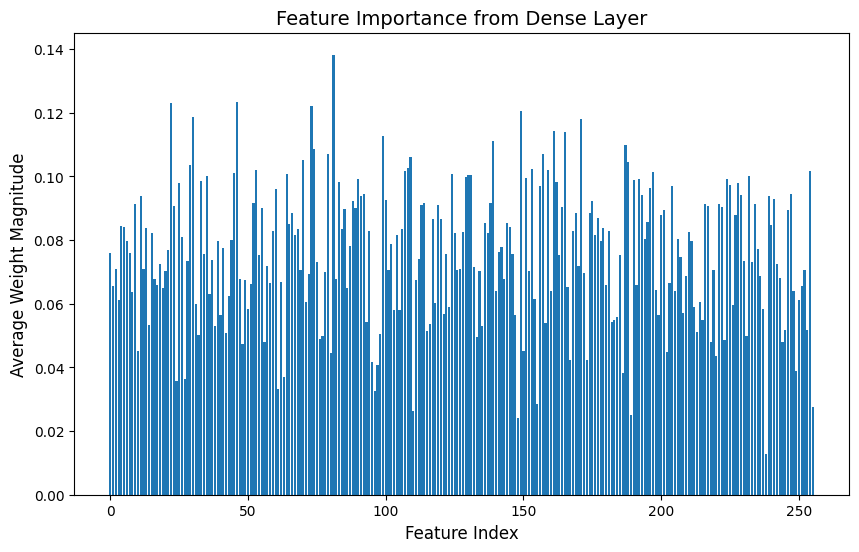

In [25]:
# ==================== FEATURE IMPORTANCE ====================
def plot_feature_importance(model, layer_name='dense_1'):
    """Plot feature importance from a dense layer"""
    weights = model.get_layer(layer_name).get_weights()[0]
    importance = np.mean(np.abs(weights), axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importance)), importance)
    plt.title('Feature Importance from Dense Layer', fontsize=14)
    plt.xlabel('Feature Index', fontsize=12)
    plt.ylabel('Average Weight Magnitude', fontsize=12)
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_feature_importance(model)